# Mask detector
 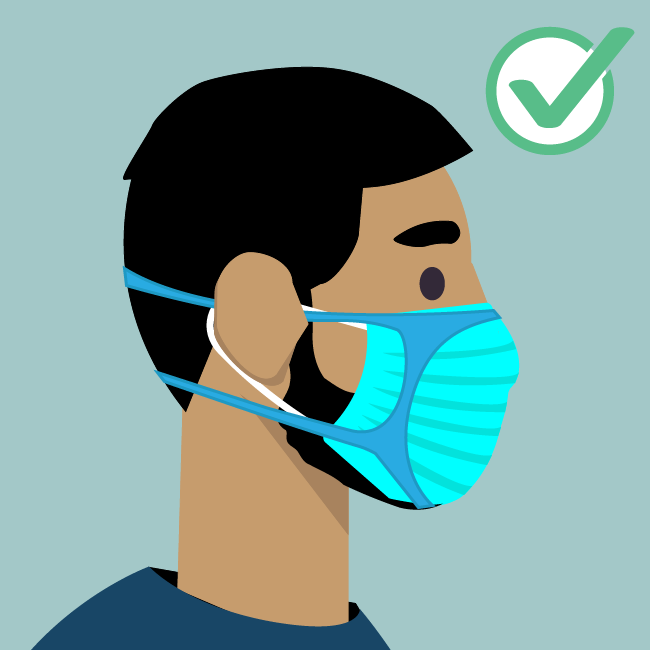

*   Due to the juncture of COVID-19 the use of masks was foreseen as a partial solution to prevent the spread of the virus.
*   The algorithm was done in order to detect wether a person is wearing or not a mask in a public place.
*   It is a highly efficient algorithm with the lowest computational cost.

# We are going to create a mask detector using the following pipeline:



1. Haar-cascade for face detection
2. Make a zoom and detect the mask 

If this does not work we will use CNN (Convolutional
Neural Networks) weights for face detection and then detect the mask.

# Import some libraries

In [ ]:
from google.colab.patches import cv2_imshow
# In parallel to OpenCV, PIL (Python Imaging Library) which is also very popular for
# Some tasks
from PIL import Image
# Requests allows to perform web requests
import requests
# Shutil is important to save data locally
import shutil
# Interactive display
import ipywidgets as widgets 
from matplotlib.colors import ListedColormap
from skimage import data
from skimage.color import rgb2hsv, hsv2rgb
from scipy import signal
# Plotly allows to have more interactive figures in Python
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Files needed

In [ ]:
#Some utilities
def d_file(url, filename):
  # Thanks to https://towardsdatascience.com/how-to-download-an-image-using-python-38a75cfa21c
  r = requests.get(url, stream = True)
  # Check if the image was successfully retrieved
  if r.status_code == 200:
      # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
      r.raw.decode_content = True      
      # Open a local file with wb (write binary) permission.
      with open(filename,'wb') as f:
          shutil.copyfileobj(r.raw, f)          
      print('Image sucessfully Downloaded: ',filename)
  else:
      print('Image Couldn\'t be retrieved')

def download_files():
  d_file('https://www.thunkmedia.com/wp-content/uploads/2016/09/Love2Learn-Elmo-Sitting-1.jpg',
          'elmo.jpg')
  d_file('http://www.suffolkgazette.com/wp-content/uploads/2017/02/cookie-monster-diabetes.jpg',
          'cookie.jpg')
  d_file('https://www.gannett-cdn.com/-mm-/b7fb0b02d7e5c245dc0fe6aa0a658192d87c8a1e/c=310-32-1169-678&r=x408&c=540x405/local/-/media/2015/09/23/USATODAY/USATODAY/635786107244170420-THE-COUNT-54620241.JPG',
          'count.jpg')
  d_file('https://vignette.wikia.nocookie.net/muppet/images/4/48/Lola_Plaza_Sesamo.jpg/revision/latest?cb=20130318070627',
          'lola.jpg')
  d_file('http://jamesvogelart.com/wp-content/uploads/2013/06/big_bird0003.jpg', 
         'bird.jpg')
  d_file('https://files.list.co.uk/images/2012/07/23/group-wo-bb-lst099416.jpg',
         'elmo2.jpg')
# Remove ticks from the histogram
def remove_ticks(p):
  p.xticks([])
  p.yticks([])

def show_image(img, cmap='none', title='none', levels = False, v_specification=False, c_plt = plt):
  '''
  Displays a frame with the image using matplotlib function and cmap 
  specification for the color map selection. title parameter includes the
  figure title.  
  '''
  mpl.rcParams['figure.dpi']= 300
  if cmap=='none':      
    c_plt.imshow(img)
  else:
    if v_specification:
      c_plt.imshow(img, cmap = cmap, vmin=0.0, vmax=1.0)
    else:
      c_plt.imshow(img, cmap = cmap)
  remove_ticks(c_plt)
  c_plt.tight_layout()
  if title!='none':
    c_plt.title(title)
  if levels == True:
    c_plt.imshow(img, cmap='hsv')
    cb = c_plt.colorbar()
    cb.set_label('Value')
  c_plt.show()

def show_hist(img, title='none', bins=100, c_plt = plt):
  '''
  This function assumes that the image parameter corresponds to a single-channel
  image, i.e. gray image.
  '''
  c_plt.hist(img.ravel(), bins = bins)
  if title!='none':
    c_plt.title(title)
  c_plt.show()

def rgb2gray(img):  
  I = 0.2126*img[:,:,0] + 0.7152*img[:,:,1] + 0.0722*img[:,:,2]
  return I

def fourier_filtering(img, mask):
  '''
  We assume img to be a gray image and mask a binarized image that points to the
  modification we will be doing to the img's fourier spectrum
  '''
  spec = np.fft.fft2(img)
  shifted_spec = np.fft.fftshift(spec);
  X_fourier = np.multiply(shifted_spec, mask)
  i_shifted_spec = np.fft.ifftshift(X_fourier)
  X_approx = np.fft.ifft2(i_shifted_spec)
  return X_approx

def gaussian_lp_filter(img, D0):
  '''
  We take the img (gray image) shape to build the mask according to D0
  '''
  M, N = img.shape
  mask = np.zeros([M,N])
  for i in range(M):
    for j in range(N):
      mask[i,j] = np.exp(-D(i,j,M,N)**2/(2*D0**2))
  return mask

def ideal_lp_filter(img, D0):
  '''
  returns a binary mask considering img's shape
  This implementation is really inefficient!
  ''' 
  M, N = img.shape
  mask = np.zeros([M,N])
  for i in range(M):
    for j in range(N):
      if D(i,j,M,N)<=D0:
        mask[i,j] = 1
  return mask

def D(u, v, M, N):
  return np.sqrt((u - M/2)**2+(v - N/2)**2)

def uniform(img,kernel_size = 3):
  '''
  We asume img is a gray image
  '''
  kernel = (1/kernel_size**2)*np.ones([kernel_size,kernel_size])
  # 'Boundary' tells the function to implement the convolution in a symmetrical 
  # way. 'Same' produces an image with the same size as the input image
  filtered = signal.convolve2d(img, kernel, boundary='symm', mode='same')
  return filtered

print('Nothing else here, for now :)')

Nothing else here, for now :)


# Face detection

In [ ]:
# Download the test image and utils files
!wget --no-check-certificate \
    https://m.economictimes.com/thumb/msid-74959025,width-1200,height-900,resizemode-4,imgsize-622136/mask_istock.jpg

##The mask template
!wget --no-check-certificate \
    https://www.pascogifts.com/files/cache/medium/files/mondkapjes-chirurgische-mond-neusmasker-categorie-2-5e7a8822508b9.jpg
    
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
    -O common.py

# These imports let you use opencv
import cv2 #opencv itself
import common #some useful opencv functions
import numpy as np # matrix manipulations

#the following are to do with this interactive notebook code
%matplotlib inline 
# The next line lets you draw inline pictures in the notebooks
from matplotlib import pyplot as plt 
# The next line allows you to control figure size 
import pylab 
# This controls the figure size in the notebook
pylab.rcParams['figure.figsize'] = (10.0, 8.0) 

--2021-04-24 04:24:13--  https://m.economictimes.com/thumb/msid-74959025,width-1200,height-900,resizemode-4,imgsize-622136/mask_istock.jpg
Resolving m.economictimes.com (m.economictimes.com)... 104.124.240.35, 2600:1417:76:192::216f, 2600:1417:76:190::216f
Connecting to m.economictimes.com (m.economictimes.com)|104.124.240.35|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://economictimes.indiatimes.com/thumb/msid-74959025,width-1200,height-900,resizemode-4,imgsize-622136/mask_istock.jpg?from=mdr [following]
--2021-04-24 04:24:13--  https://economictimes.indiatimes.com/thumb/msid-74959025,width-1200,height-900,resizemode-4,imgsize-622136/mask_istock.jpg?from=mdr
Resolving economictimes.indiatimes.com (economictimes.indiatimes.com)... 104.124.240.35, 2600:1417:76:190::216f, 2600:1417:76:192::216f
Connecting to economictimes.indiatimes.com (economictimes.indiatimes.com)|104.124.240.35|:443... connected.
HTTP request sent, awaiting response

(900, 1200, 3)


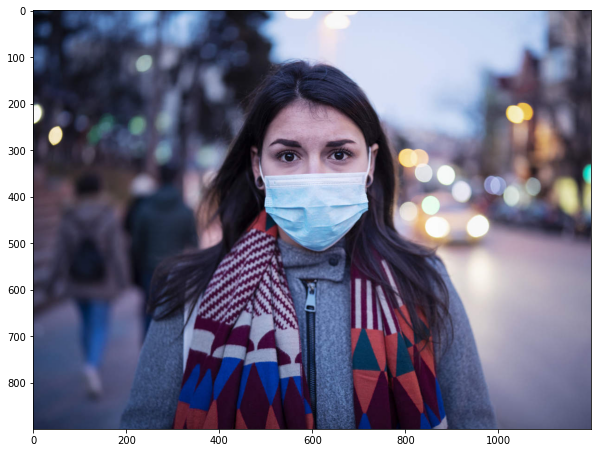

In [ ]:
base_image = cv2.imread('mask_istock.jpg')
grey = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))
print(base_image.shape)

# Creating some useful functions

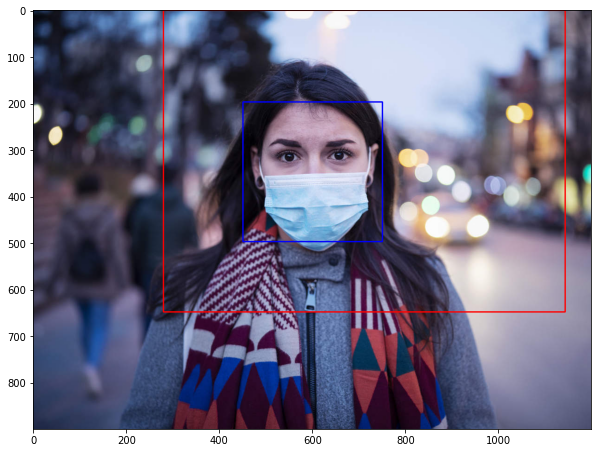

In [ ]:
# We detect the face of the person
test_image = cv2.imread('mask_istock.jpg')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(grey, 1.3, 5)
# Read the template
template = cv2.imread('mondkapjes-chirurgische-mond-neusmasker-categorie-2-5e7a8822508b9.jpg',0)

# Percent of original size
scale_percent = 90 
width = int(template.shape[1] * scale_percent / 100)
height = int(template.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
template = cv2.resize(template, dim, interpolation = cv2.INTER_AREA)
w_template, h_template = template.shape[::-1]

for (x,y,w,h) in faces:
     cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)

     meth = 'cv2.TM_CCORR_NORMED'
     method = eval(meth)
     res = cv2.matchTemplate(grey,template,method)
     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
     top_left = max_loc
     bottom_right = (top_left[0] + w_template, top_left[1] + h_template)
     cv.rectangle(test_image,top_left, bottom_right, (0,0,255),2)

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

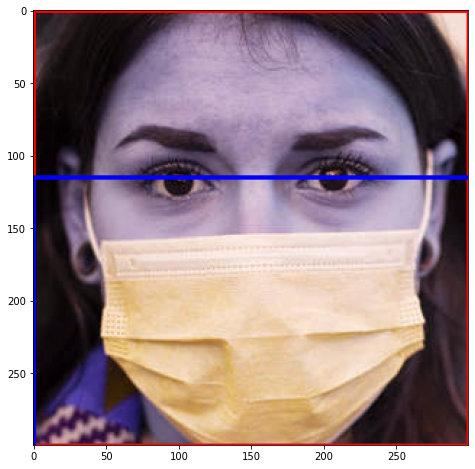

In [ ]:
#We detect the face of the person
test_image = cv2.imread('mask_istock.jpg')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(grey, 1.3, 5)

#Read the template
template = cv2.imread('/content/mask_template.jpg')
temp_gray = rgb2gray(template)
temp_filt = np.abs(fourier_filtering(rgb2gray(template), gaussian_lp_filter(template[:,:,0], 50)))
f_temp = uniform(temp_filt/np.max(temp_filt))
# OpenCV requires "uint8" data types
f_temp = np.uint8(f_temp/f_temp.max()*255)

# Percent of original size
scale_percent = 90 
width = int(f_temp.shape[1] * scale_percent / 100)
height = int(f_temp.shape[0] * scale_percent / 100)
dim = (width, height)
  
# Resize image
f_temp = cv2.resize(f_temp, dim, interpolation = cv2.INTER_AREA)

w, h = f_temp.shape

for (x,y,w,h) in faces:
     cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
     # Select the face that is recognized in grey
     face_frame = test_image[y:y+h,x:x+w]

     # Make some filtering in the face frame 
     face_frame_gray = rgb2gray(face_frame)
     face_filtering = np.abs(fourier_filtering(face_frame_gray,  gaussian_lp_filter(face_frame_gray, 50)))
     f_full = uniform(face_filtering/np.max(face_filtering))
     # OpenCV requires uint8 data types
     f_full = np.uint8(f_full/f_full.max()*255)

     # Then we apply a matching template
     meth = 'cv2.TM_CCORR_NORMED'
     method = eval(meth)
     res = cv2.matchTemplate(f_full,f_temp,method)
     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
     top_left = max_loc
     bottom_right = (top_left[0] + w_template, top_left[1] + h_template)
     cv.rectangle(face_frame,top_left, bottom_right, (0,0,255),2)

plt.imshow(face_frame)
#plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))